Models for Further Tuning and Analysis:
1. Logistic Regression — TF-IDF + Style + class_weight
2. Random Forest — TF-IDF(2000) + ROS + Style

(In consideration) XGBoost — TF-IDF(2000) + Style + ROS


Since we want to compare which model generelizes better, we'll comapre based on the AUC.

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.sparse import hstack, csr_matrix
from src.utils import load_cleaned_data, metrics, plot_confusion_matrix, store_metrics  # Adjust import if needed
from src.classifier import save_full_model
from sklearn.metrics import make_scorer, f1_score

In [87]:
results = []  # to store them

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'balanced_accuracy': 'balanced_accuracy'
}

In [88]:
train_df = load_cleaned_data("byarticle_clean.tsv")
test_df = load_cleaned_data("byarticle_clean_test.tsv")

In [89]:
style_features = ['uppercase_ratio', 'exclamation_count', 'avg_sentence_length']
X_train_text = train_df['full_text']
X_test_text = test_df['full_text']
y_train = train_df['label']
y_test = test_df['label']



#GridSearchCV for Logistic Regression

tune:

    C — regularization strength (lower = stronger regularization)

    solver — optimization algorithm (liblinear, saga, etc.)

    penalty — L1 or L2 (depending on solver)

    (Already using) class_weight='balanced'

In [ ]:
# === TF-IDF Vectorizer ===
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# === Style Feature Scaling ===
scaler = MinMaxScaler()
X_train_style = csr_matrix(scaler.fit_transform(train_df[style_features]))
X_test_style = csr_matrix(scaler.transform(test_df[style_features]))

# === Combine Text + Style Features ===
X_train_comb = hstack([X_train_tfidf, X_train_style])
X_test_comb = hstack([X_test_tfidf, X_test_style])


Best params: {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC-AUC on CV: 0.8138514631797225
Accuracy: 0.77
Balanced Accuracy: 0.77
Precision: 0.79
Recall: 0.75
F1: 0.77
AUC: 0.84


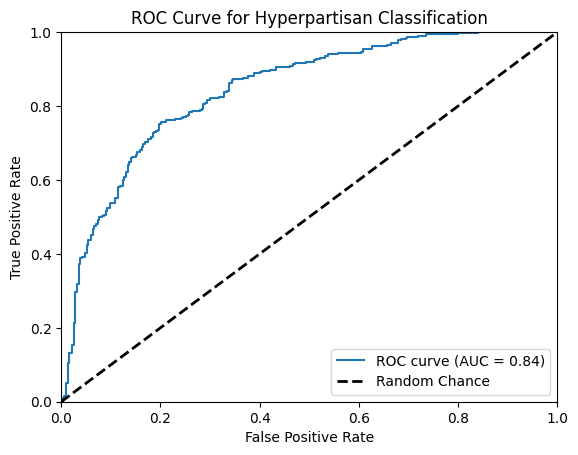

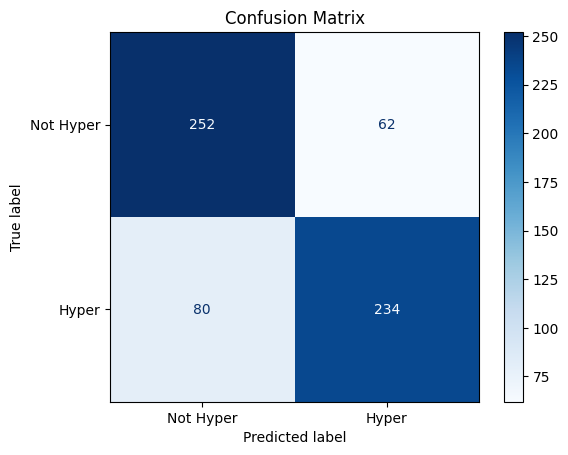

In [ ]:
param_grid = {
    'C': [0.05, 0.1, 0.2, 0.5, 1, 2], #flexibility of a model, lower more regularization
    'solver': ['liblinear'],        # Only liblinear: stable and sufficient, saga too oodly, but supports larger data
    'penalty': ['l1', 'l2']               # Just l2: more generalizable for TF-IDF, added l1 for a test
}


grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',  # Choose best model based on AUC, RoBERTa outputs probabilities → AUC is fairer than F1 alone
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_comb, y_train)

print("Best params:", grid.best_params_)
print("Best ROC-AUC on CV:", grid.best_score_)

# === Final Evaluation ===
best_lr = grid.best_estimator_

Accuracy: 0.72
Balanced Accuracy: 0.72
Precision: 0.66
Recall: 0.90
F1: 0.77
AUC: 0.84


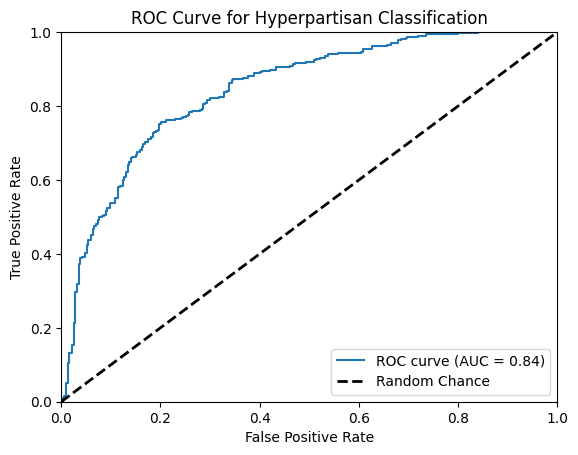

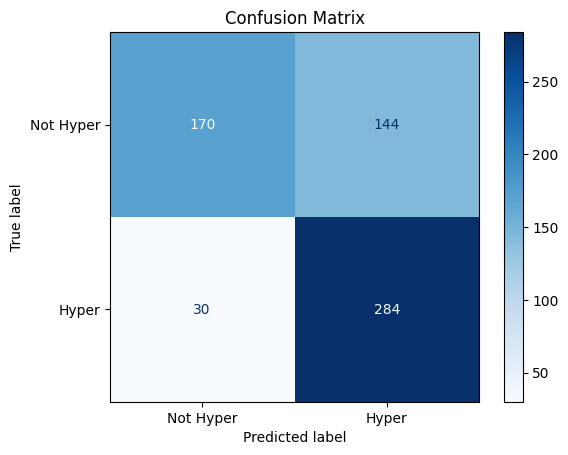

In [ ]:
# === Predict with custom threshold ===
threshold = 0.5 # later: test 0.5 or 0.45 or 0.4 too
y_proba = best_lr.predict_proba(X_test_comb)[:, 1]
y_pred = (y_proba > threshold).astype(int)


metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)

# === Store results ===
store_metrics(results, "Logistic Regression", f"TF-IDF + Style + class_weight (Tuned @ {threshold})", y_test, y_pred, y_proba)

🧪 Best Baseline LR (untuned):

    Setup: TF-IDF + Style + class_weight

    F1 Score: 0.758

    AUC: 0.84

    Accuracy: 0.76

    Balanced Accuracy: 0.76

    Precision: 0.764

    Recall: 0.752

The tuned LR model is marginally better overall, especially in F1 and precision, while keeping the same AUC.

AUC staying the same is actually a good sign — it means tuning didn’t hurt the model’s ability to rank or separate classes.

# GridSearch for RandomForest

n_estimators:	Number of trees → More trees = better stability (but slower)
max_depth:	Controls overfitting — tune to find sweet spot
min_samples_leaf:	Controls minimum examples per leaf — prevents overly deep trees
max_features:	Number of features considered at each split — can improve generalization

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}


In [92]:
# === TF-IDF (2000 features) ===
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english", ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_text)
X_test_vec = vectorizer.transform(X_test_text)

# === Style Features ===
scaler = MinMaxScaler()
X_train_style = csr_matrix(scaler.fit_transform(train_df[style_features]))
X_test_style = csr_matrix(scaler.transform(test_df[style_features]))

# === Combine Text + Style ===
X_train_comb = hstack([X_train_vec, X_train_style])
X_test_comb = hstack([X_test_vec, X_test_style])

# === Convert to dense for RF ===
X_train_comb = X_train_comb.toarray()
X_test_comb = X_test_comb.toarray()

# === Oversampling ===
ros = RandomOverSampler(random_state=0)
X_train_final, y_train_final = ros.fit_resample(X_train_comb, y_train)

In [93]:
grid = GridSearchCV(
    RandomForestClassifier(random_state=0),
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',  # Again, ROC-AUC is best for your goals
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_final, y_train_final)

print("Best params:", grid.best_params_)
print("Best ROC-AUC on CV:", grid.best_score_)

# Final eval
best_rf = grid.best_estimator_


Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}
Best ROC-AUC on CV: 0.9474104185486298


In [94]:
save_full_model(
    model=best_rf,
    vectorizer=vectorizer,
    scaler=scaler,
    metadata={
        "threshold": 0.4,
        "cv_auc": 0.947,
        "best_params": best_rf.get_params(),
        "features": {
            "text": "TF-IDF (2000, bigrams, stopwords='english')",
            "style": ["uppercase_ratio", "exclamation_count", "avg_sentence_length"]
        }
    },
    output_dir="models",
    name="best_rf"
)


 Model, vectorizer, scaler, and metadata saved to models/


Accuracy: 0.73
Balanced Accuracy: 0.73
Precision: 0.83
Recall: 0.59
F1: 0.69
AUC: 0.85


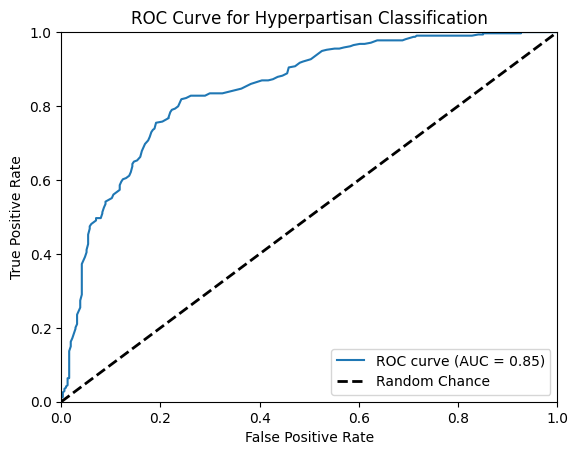

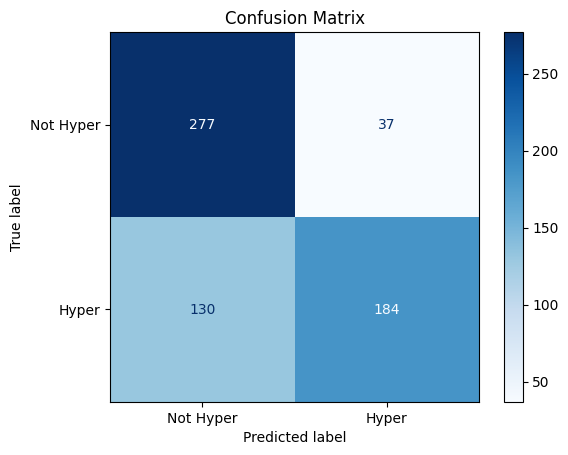

In [ ]:
# === Predict with custom threshold ===
threshold = 0.5 # later: test 0.5 or 0.45 or 0.4 too
y_proba = best_rf.predict_proba(X_test_comb)[:, 1]
y_pred = (y_proba > threshold).astype(int)

# === Evaluate ===
metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)
store_metrics(results, "Random Forest", f"TF-IDF(2000) + Style + ROS (Tuned @ {threshold})", y_test, y_pred, y_proba)

Settign threshold to 0.4, making more sensitive — if the model is even 40% sure it's hyperpartisan, I’ll label it as hyperpartisan. This as expected increase recall but decresed precision (more fp). Model is quite adaptive.

# Testing on XGBOOST


In [ ]:
# 4 min 53s
param_grid = {
    'n_estimators': [200],  #100 faster, 200 assumably stronger learning
    'max_depth': [6, 8],    #keeping it >10 for such data
    'learning_rate': [0.05],
    'subsample': [0.8], # 1 or 0.8
    'min_child_weight': [1, 3],  # light-touch pruning
    'colsample_bytree': [0.7, 1],
    'scale_pos_weight': [1, y_train.value_counts()[0] / y_train.value_counts()[1]] #pos_weight


}


In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

grid = GridSearchCV(
    clf,
    param_grid=param_grid,
    scoring = scoring,
    refit='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_final, y_train_final)

print("Best params:", grid.best_params_)
print("Best ROC-AUC on CV:", grid.best_score_)
best_xgb = grid.best_estimator_


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:42:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200, 'scale_pos_weight': np.float64(1.7100840336134453), 'subsample': 0.8}
Best ROC-AUC on CV: 0.9460659997546477


Accuracy: 0.75
Balanced Accuracy: 0.75
Precision: 0.78
Recall: 0.70
F1: 0.74
AUC: 0.84


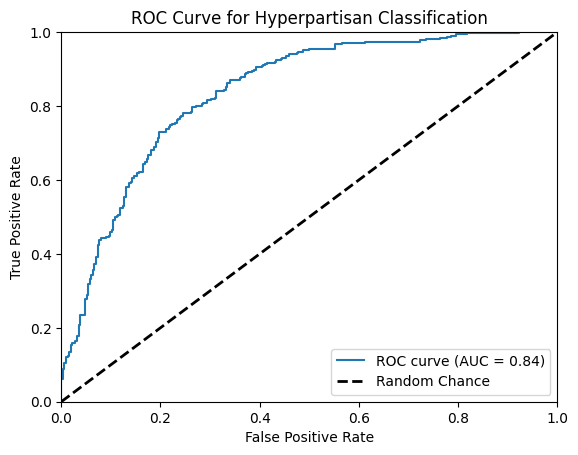

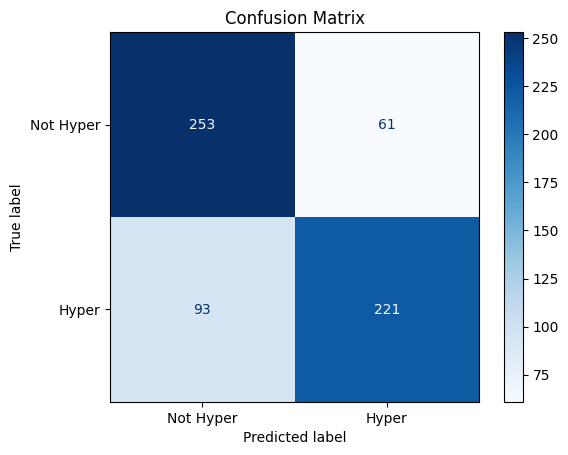

In [ ]:
threshold = 0.5 # later: test 0.5 or 0.45 or 0.4 too
y_proba = best_xgb.predict_proba(X_test_comb)[:, 1]
y_pred = (y_proba > threshold).astype(int)

metrics(y_test, y_pred, y_proba)
plot_confusion_matrix(y_test, y_pred)
store_metrics(results, "XGBoost", f"TF-IDF(2000) + Style + scale_pos_weight (Tuned @ {threshold})", y_test, y_pred, y_proba)


In [ ]:
# Save all results to CSV
results_df = pd.DataFrame(results)
print("\n=== Model Comparison Table ===")
print(results_df.to_string(index=False))


=== Model Comparison Table ===
              Model                                                  Setup  Accuracy  Balanced Accuracy  Precision  Recall  F1 Score   AUC
            XGBoost  TF-IDF(2000) + Style + scale_pos_weight (Tuned @ 0.5)     0.755              0.755      0.784   0.704     0.742 0.836
            XGBoost TF-IDF(2000) + Style + scale_pos_weight (Tuned @ 0.45)     0.763              0.763      0.770   0.748     0.759 0.836
            XGBoost  TF-IDF(2000) + Style + scale_pos_weight (Tuned @ 0.4)     0.768              0.768      0.761   0.780     0.770 0.836
      Random Forest               TF-IDF(2000) + Style + ROS (Tuned @ 0.5)     0.734              0.734      0.833   0.586     0.688 0.845
      Random Forest              TF-IDF(2000) + Style + ROS (Tuned @ 0.45)     0.774              0.774      0.801   0.729     0.763 0.845
      Random Forest               TF-IDF(2000) + Style + ROS (Tuned @ 0.4)     0.772              0.772      0.745   0.828     0.784 0

Random Forest (chosen)-> will use it for RoBERTa comparison + by-publisher
XGBoost (very strong)	 - > Possible backup or ensemble
Logistic Regression -> possible saved to ensemble or report in detail